# wavefunction plots

In [328]:
from numpy import *
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib import colors
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from time import time

# path stuff
import sys
sys.path.append('/images')

from arc import *
from scipy.special import sph_harm as ylm

# my special sauce
from physconsts import *
from rbconsts import *

from field_funcs import *

# other
mpl.rcParams.update(mpl.rcParamsDefault)

#### layout stuff
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

# define our atom
atom=Rubidium(87)

In [ ]:
# a note about saving the figure: use the following to get the correct 
# background color
# savefig('figname.png', facecolor=fig.get_facecolor(), transparent=True)


## fine structure wavefunctions

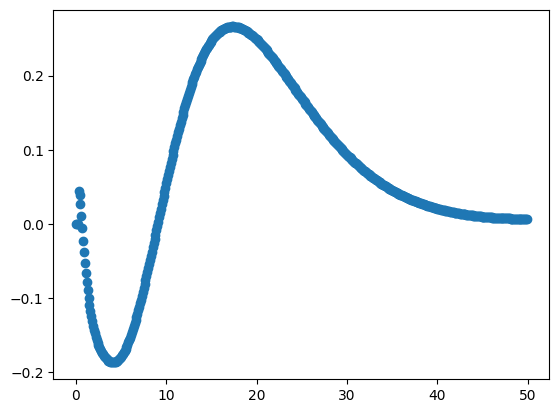

In [200]:
def get_psi_r(n,l,j,rmax,rmin=0,dr=0.001,vector=False):
    """
    Returns the an interpolating funcion for psi_{n,l,j}, taking argument radial position r 
    """
    rmin = max(amin(rmin),atom.alphaC**(1/3.0)/10)
    rmax = min(amax(rmax),2.0*n*(n+15.0))

    rpts, radialpts = atom.radialWavefunction(l,0.5,j,\
                                     atom.getEnergy(n, l, j)/27.211,\
                                     rmin,\
                                     rmax,\
                                     step=dr)

    # ensure that psi goes to zero at the origin
#     intrp_pts = array([0] + list(rpts))
#     psi_pts = array([0] + list(radialpts))
    intrp_pts = rpts
    psi_pts = radialpts
    if vector:
        psi_radial = lambda x: where(x > rmin, interp(x, intrp_pts, psi_pts), 0)
    else:
        psi_radial = lambda x: interp(x, intrp_pts, psi_pts) if x > rmin else 0

    return psi_radial

# wavefunction params
n=5
l=2
j=3/2

rf = 50
psi_r = get_psi_r(n,l,j,rmax=rf)

xpts = arange(0,rf,.1)
plt.scatter(xpts, [psi_r(x) for x in xpts])
plt.show()

In [297]:
# plot a wavefunction with both radial and angular parts.
# the angular part ends up being really slow. try with one term to diagnose.

states = [
#     [5,0,1/2,1/2],
#     [5,1,1/2,1/2],
#     [5,1,3/2,1/2],
    [5,1,3/2,3/2],
    [5,2,5/2,1/2],
    [5,2,5/2,3/2],
    [5,2,5/2,5/2]
]

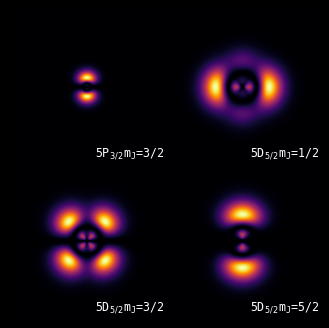

In [332]:
# use gridspec instead of subplots

l_dict = {0:"S",1:"P",2:"D",3:"F"}
j_dict = {0.5:"1/2",1.5:"3/2",2.5:"5/2"} # do this better in the future

rmax = 50 # max radius

plt.set_cmap('inferno') # set the colormap

plt.close()
rows = cols = int(ceil(sqrt(len(states))))
plt.figure(figsize=(4,4),facecolor='black')
gs = gridspec.GridSpec(rows,cols)
gs.update(wspace=0,hspace=0)

def configure_ax(ax):
    ax.set_aspect('equal')
    ax.set_axis_off()

# loop over states, plot each
for i,state in enumerate(states):

    # wavefunction params
    n,l,j,mj = state

    ylm_safe = lambda m,l,phi,theta: ylm(m,l,phi,theta) if abs(m) <= l else 0

    psi_r = get_psi_r(n,l,j,rmax=rmax,vector=True)
    psi_ylm = lambda theta,phi: float(clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj))*ylm_safe(mj-1/2,l,phi,theta) + \
                                 float(clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj))*ylm_safe(mj+1/2,l,phi,theta)

    pts = 500
    xarr,midpt,rho,phi = get_meshgrid(rmax,pts,polar=True)
    theta = full(rho.shape, pi/2) # use approx. to pi to avoid div by zero

    ylm_mesh = psi_ylm(phi,theta)
    r_mesh = psi_r(rho)

    psi_mesh = ylm_mesh*r_mesh
    prob_mesh = abs(psi_mesh)**2
#     print(amax(prob_mesh))
    prob_mesh /= amax(prob_mesh)
#     print(prob_mesh)

#     print("n={},l={},j={},mj={}".format(*state))
        
    ax = plt.subplot(gs[i])
    plt.axis('on')
    
    # settings that apply to each ax
    configure_ax(ax)
    jstr = "".join([r'$_{}$'.format(x) for x in j_dict[j]]) # build the J subscript
    ax.text(0.55*pts,0.95*pts,s=f'{n}{l_dict[l]}'+jstr+r'$\mathregular{m_J}$'+'={}'.format(j_dict[mj]),
            color='white',size='small',family='monospace')
    
    cax = ax.imshow(prob_mesh) #, extent=[-hw,hw,-hw,hw])
    # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
#     cbar = fig.colorbar(cax)
# plt.subplots_adjust(hspace=0.0,wspace=0.0,right=0.7)
plt.show()

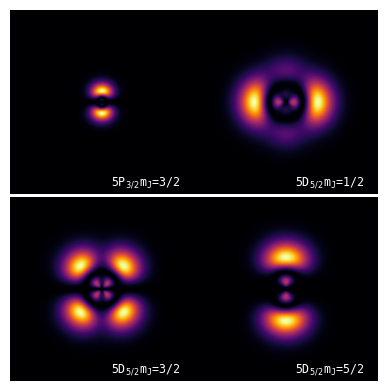

In [327]:
l_dict = {0:"S",1:"P",2:"D",3:"F"}
j_dict = {0.5:"1/2",1.5:"3/2",2.5:"5/2"} # do this better in the future

rmax = 50 # max radius

plt.set_cmap('inferno') # set the colormap

plt.close()
rows = cols = int(ceil(sqrt(len(states))))
fig, axes = plt.subplots(rows,cols)

def configure_ax(ax):
    ax.set_aspect('equal')
    ax.set_axis_off()

# loop over states, plot each
for state,ax in zip(states, axes.flatten()):

    # wavefunction params
    n,l,j,mj = state

    ylm_safe = lambda m,l,phi,theta: ylm(m,l,phi,theta) if abs(m) <= l else 0

    psi_r = get_psi_r(n,l,j,rmax=rmax,vector=True)
    psi_ylm = lambda theta,phi: float(clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj))*ylm_safe(mj-1/2,l,phi,theta) + \
                                 float(clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj))*ylm_safe(mj+1/2,l,phi,theta)

    pts = 500
    xarr,midpt,rho,phi = get_meshgrid(rmax,pts,polar=True)
    theta = full(rho.shape, pi/2) # use approx. to pi to avoid div by zero

    ylm_mesh = psi_ylm(phi,theta)
    r_mesh = psi_r(rho)

    psi_mesh = ylm_mesh*r_mesh
    prob_mesh = abs(psi_mesh)**2
#     print(amax(prob_mesh))
    prob_mesh /= amax(prob_mesh)
#     print(prob_mesh)

#     print("n={},l={},j={},mj={}".format(*state))
        
    # settings that apply to each ax
    configure_ax(ax)
    jstr = "".join([r'$_{}$'.format(x) for x in j_dict[j]]) # build the J subscript
    ax.text(0.55*pts,0.95*pts,s=f'{n}{l_dict[l]}'+jstr+r'$\mathregular{m_J}$'+'={}'.format(j_dict[mj]),
            color='white',size='small',family='monospace')
    
    cax = ax.imshow(prob_mesh) #, extent=[-hw,hw,-hw,hw])
    # cax.set_norm(colors.Normalize(vmin=0, vmax=1))
#     cbar = fig.colorbar(cax)
plt.subplots_adjust(hspace=0.0,wspace=0.0,right=0.7)
plt.show()

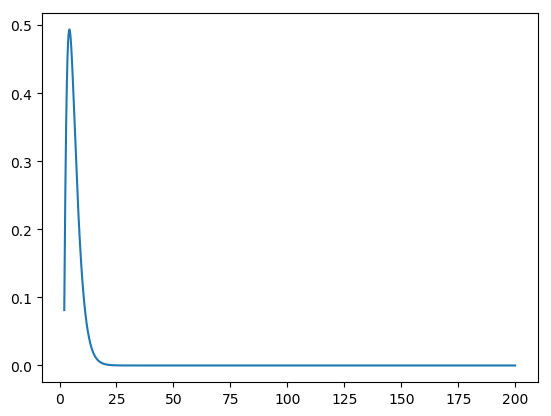

In [32]:
s = 0.5
l = 0
j = 0.5
n = 5

rmin = rb.alphaC**(1/3)
rmax = 2.0*n*(n+15.0)

rpts, radial = rb.radialWavefunction(
    l,s,j,
    rb.getEnergy(n,l,j)/27.211, # don't know why 27.211 
    rmin,
    rmax,
    step=0.001
)

plt.plot(rpts, radial) 

1.0
0.0


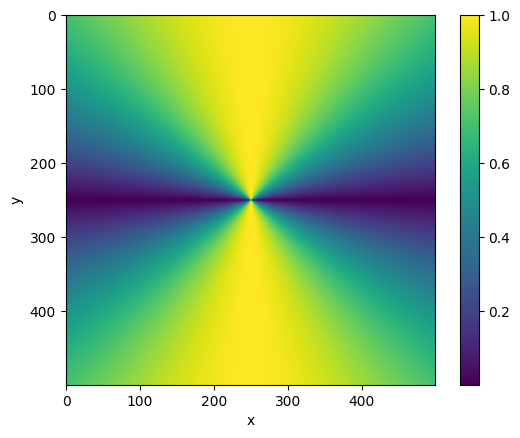

In [196]:
# spherical harmonic plots - fine structure

l = 1
j = 3/2
mj = 3/2

psi_ylm = lambda theta,phi: float(clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj))*ylm_safe(mj-1/2,l,phi,theta) + \
                                 float(clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj))*ylm_safe(mj+1/2,l,phi,theta)

print(float(clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj)))
print(float(clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj)))

xarr,midpt,rho,phi = get_meshgrid(rmax,pts,polar=True)
theta = full(rho.shape, 3.14) # use approx. to pi to avoid div by zero

ylm_mesh = psi_ylm(phi,theta)

ylmpts = abs(ylm_mesh)/amax(abs(ylm_mesh))

fig,ax = figax(xlabel='x', ylabel='y')
# fig.dpi=100
cax = ax.imshow(ylmpts)#, extent=[-hw,hw,-hw,hw])
# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)
plt.show()

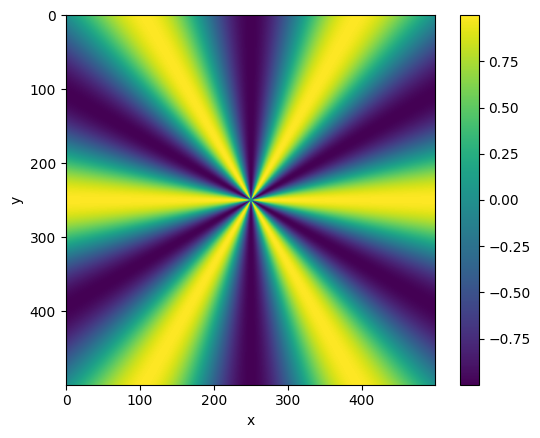

In [85]:
# spherical harmonic plots

hw=10 # units in a0k
pts = 500
xarr,midpt,rho,phi = get_meshgrid(hw,pts,polar=True)
theta = full(rho.shape, 0)

fig,ax = figax(xlabel='x', ylabel='y')
# fig.dpi=100
l = 6
m = 6
theta = pi/2
ylmpts = real(ylm(m,l,phi,theta))/amax(abs(ylm(m,l,phi,theta)))
cax = ax.imshow(ylmpts)#, extent=[-hw,hw,-hw,hw])
# cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)
plt.show()

In [29]:
2.0*100*(100+15.0)

23000.0

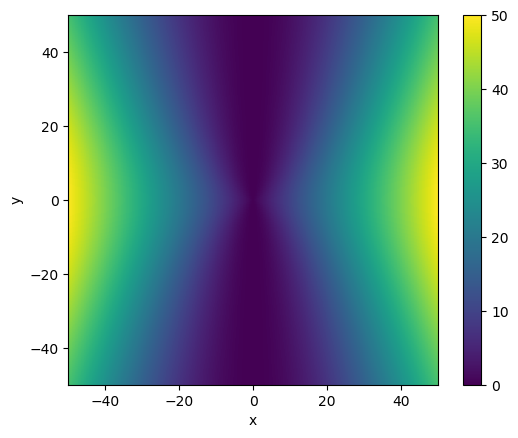

In [59]:
fig,ax = figax(xlabel='x', ylabel='y')
fig.dpi=100
# ax.set_title(rf'Input Field Amplitude | dy/dx={dy/dx:0.2f}') #$t_{{spot}}$={1-r_aper:0.2f}, $t_{{plate}}$={t_plate:0.2f}',)
cax = ax.imshow(rho*cos(phi)**2, extent=[-hw,hw,-hw,hw])
cax.set_norm(colors.Normalize(vmin=0, vmax=50))
cbar = fig.colorbar(cax)

In [68]:
# create a mesh grid lying in the plane phi=0

# evaluate the wavefunction over the mesh

def wavefunc_fs(atom,n,l,j,mj,r,theta,phi):
    """
    spatial coordinates are to be meshes rather than scalar
    
    theta in [0,pi] (polar)
    phi in [0,2*pi] (azimuthal)
    """
    
    psi = full(r.shape, 0, dtype=float)
    
    rmin = max(amin(r),atom.alphaC**(1/3.0))
    rmax = min(amax(r),2.0*n*(n+15.0))
    dr = 0.001
    
    radialpts = atom.radialWavefunction(l,0.5,j,\
                                     atom.getEnergy(n, l, j)/27.211,\
                                     rmin,\
                                     rmax,\
                                     step)
    
    rpts = arange(rmin,rmax+dr,dr)
    
    psi_radial = lambda x: interp(x, rpts, radialpts)
    
    psi_angular = lambda theta,phi: (clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj)*ylm(m-1/2,l,phi,theta) + 
                                     clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj)*ylm(m+1/2,l,phi,theta))
    
    psi = psi_radial(r)*psi_angular

    return psi

# plot the mesh

In [69]:
ylmpts = abs(ylm(0,1,phi,0))/amax(abs(ylm(0,0,phi,0)))

In [21]:
rpts

array([ 2.08592247,  2.38477693,  2.70363139,  3.04248585,  3.40134031,
        3.78019477,  4.17904923,  4.59790369,  5.03675815,  5.49561261,
        5.97446707,  6.47332152,  6.99217598,  7.53103044,  8.0898849 ,
        8.66873936,  9.26759382,  9.88644828, 10.52530274, 11.1841572 ,
       11.86301166, 12.56186612, 13.28072058, 14.01957504, 14.7784295 ,
       15.55728396, 16.35613842, 17.17499288, 18.01384734, 18.8727018 ,
       19.75155626, 20.65041072, 21.56926517, 22.50811963, 23.46697409])

In [104]:
float(clebsch_gordan(l,1/2,j,mj-1/2,1/2,mj))

1.0

In [159]:
imag(ylm(mj+1/2,l,phi,theta))

array([[ 0.24430126,  0.24479133,  0.24528237, ...,  0.24528237,
         0.24479133,  0.24430126],
       [ 0.2438102 ,  0.24430126,  0.2447933 , ...,  0.2447933 ,
         0.24430126,  0.2438102 ],
       [ 0.24331618,  0.24380822,  0.24430126, ...,  0.24430126,
         0.24380822,  0.24331618],
       ...,
       [-0.24331618, -0.24380822, -0.24430126, ..., -0.24430126,
        -0.24380822, -0.24331618],
       [-0.2438102 , -0.24430126, -0.2447933 , ..., -0.2447933 ,
        -0.24430126, -0.2438102 ],
       [-0.24430126, -0.24479133, -0.24528237, ..., -0.24528237,
        -0.24479133, -0.24430126]])

In [103]:
float(clebsch_gordan(l,1/2,j,mj+1/2,-1/2,mj))

0.0

In [70]:
ylmpts

array([[1.73205081, 1.73205081, 1.73205081, ..., 1.73205081, 1.73205081,
        1.73205081],
       [1.73205081, 1.73205081, 1.73205081, ..., 1.73205081, 1.73205081,
        1.73205081],
       [1.73205081, 1.73205081, 1.73205081, ..., 1.73205081, 1.73205081,
        1.73205081],
       ...,
       [1.73205081, 1.73205081, 1.73205081, ..., 1.73205081, 1.73205081,
        1.73205081],
       [1.73205081, 1.73205081, 1.73205081, ..., 1.73205081, 1.73205081,
        1.73205081],
       [1.73205081, 1.73205081, 1.73205081, ..., 1.73205081, 1.73205081,
        1.73205081]])

In [51]:
ylm(0,0,phi,theta)

array([[0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       ...,
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j],
       [0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j, ...,
        0.28209479+0.j, 0.28209479+0.j, 0.28209479+0.j]])

In [63]:
hw=50 # units in a0k
pts = 500
xarr,midpt,rho,phi = get_meshgrid(hw,pts,polar=True)
theta = full(rho.shape, 0)

In [61]:
arange(1,4+1,1)

array([1, 2, 3, 4])

In [15]:
print(type(rpts))

<class 'numpy.ndarray'>


In [20]:
len(rpts)

35

In [22]:
arange(2,25,1)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

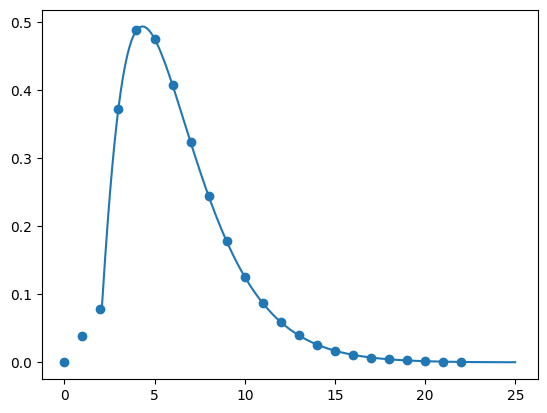

In [39]:
# plot the radial wavefunction with the interpolated function

r = [0,25] # wavefunction boundaries

n=5
l=0
j=1/2

rmin = max(amin(r),atom.alphaC**(1/3.0))
rmax = min(amax(r),2.0*n*(n+15.0))
dr = .001

rpts, radialpts = atom.radialWavefunction(l,0.5,j,\
                                 atom.getEnergy(n, l, j)/27.211,\
                                 rmin,\
                                 rmax,\
                                 step=dr)

# ensure that psi goes to zero at the origin
intrp_pts = array([0] + list(rpts))
psi_pts = array([0] + list(radialpts))
psi_radial = lambda x: interp(x, intrp_pts, psi_pts)

plt.plot(rpts, radialpts)

xpts = arange(0,23,1)
plt.scatter(xpts, [psi_radial(x) for x in xpts])
plt.show()

In [41]:
hvs = lambda x: 1 if x > 0 else 0

In [43]:
hvs(-1)

0

In [57]:
rho.shape

(500, 500)